In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from synthete_analysis.analysis import (
    get_all_synthete_stats_vectorized,
    get_all_synthete_means_vectorized,
    compute_all_synthete_means,
    compute_group_regression
)
from synthete_analysis.retrieval import query_imf
from synthete_analysis.cleanup import normalize_metric_dict, add_all_years
from synthete_analysis.constants import (
    CONCENTRATED_IN_OIL,
    PB_METRIC,
    GDP_PER_CAPITA_METRIC,
)

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [19]:
all_countries = query_imf("https://www.imf.org/external/datamapper/api/v1/countries")[
    "countries"
]
indicators = query_imf("https://www.imf.org/external/datamapper/api/v1/indicators")[
    "indicators"
]
groups = query_imf("https://www.imf.org/external/datamapper/api/v1/groups")["groups"]

# PRIMARY BALANCE RETRIEVAL AND PROCESSING
# Retrieve and process government primary balance data for 1990–2019
primary_balance = query_imf(
    f"https://www.imf.org/external/datamapper/api/v1/{PB_METRIC}"
)["values"][PB_METRIC]

# Cleanup: normalize and add year columns, restrict to available and valid years/countries
primary_balance_df = pl.DataFrame(normalize_metric_dict(primary_balance))
primary_balance_df = add_all_years(primary_balance_df)
primary_balance_df = (
    primary_balance_df.filter(
        (pl.col("year") >= 1990)
        & (pl.col("year") <= 2019)
        & (pl.col("country").is_in(all_countries.keys()))
        & (~pl.col("country").is_in(CONCENTRATED_IN_OIL))
    )
    .sort("year")
    .with_columns(pl.col("value").fill_null(strategy="forward").over("country"))
)
# Compute the average primary balance for each country in this period
average_primary_balance_df = (
    primary_balance_df.group_by(pl.col("country"))
    .agg(pl.col("value").mean())
    .rename({"value": "average_primary_balance"})
)

# GDP PER CAPITA RETRIEVAL AND PROCESSING
gdp_per_capita = query_imf(
    f"https://www.imf.org/external/datamapper/api/v1/{GDP_PER_CAPITA_METRIC}"
)["values"][f"{GDP_PER_CAPITA_METRIC}"]
gdp_per_capita_df = pl.DataFrame(normalize_metric_dict(gdp_per_capita))
gdp_per_capita_df = add_all_years(gdp_per_capita_df)
gdp_per_capita_df = (
    gdp_per_capita_df.filter(
        (pl.col("year") >= 1990)
        & (pl.col("year") <= 2019)
        & (pl.col("country").is_in(all_countries.keys()))
        & (~pl.col("country").is_in(CONCENTRATED_IN_OIL))
    )
    .sort("year")
    .with_columns(pl.col("value").fill_null(strategy="forward").over("country"))
)
average_gdp_per_capita_df = (
    gdp_per_capita_df.group_by(pl.col("country"))
    .agg(pl.col("value").mean())
    .rename({"value": "average_gdp_per_capita"})
)
real_gdp_per_capita_growth_df = (
    gdp_per_capita_df.filter(pl.col("year").is_between(1990, 2019))
    .group_by("country")
    .agg(
        [
            pl.col("value").filter(pl.col("year") == 1990).first().alias("start_value"),
            pl.col("value").filter(pl.col("year") == 2019).first().alias("end_value"),
            pl.col("value")
            .filter(pl.col("value").is_not_null())
            .count()
            .alias("valid_years"),
        ]
    )
    .filter(
        (pl.col("start_value").is_not_null())
        & (pl.col("end_value").is_not_null())
        & (pl.col("start_value") > 0)
        & (pl.col("valid_years") >= 2)
    )
    .with_columns(
        [
            (
                (pl.col("end_value") / pl.col("start_value")) ** (1 / (2019 - 1990)) - 1
            ).alias("cagr")
        ]
    )
    .select(["country", "cagr"])
)

# COMBINE DATAFRAMES
# Join average GDP per capita and real GDP per capita growth
all_data_df = (
    average_gdp_per_capita_df.join(real_gdp_per_capita_growth_df, on="country")
    .join(average_primary_balance_df, on="country", how="left")
    .sort("average_gdp_per_capita")
    .with_row_index(name="index")
)

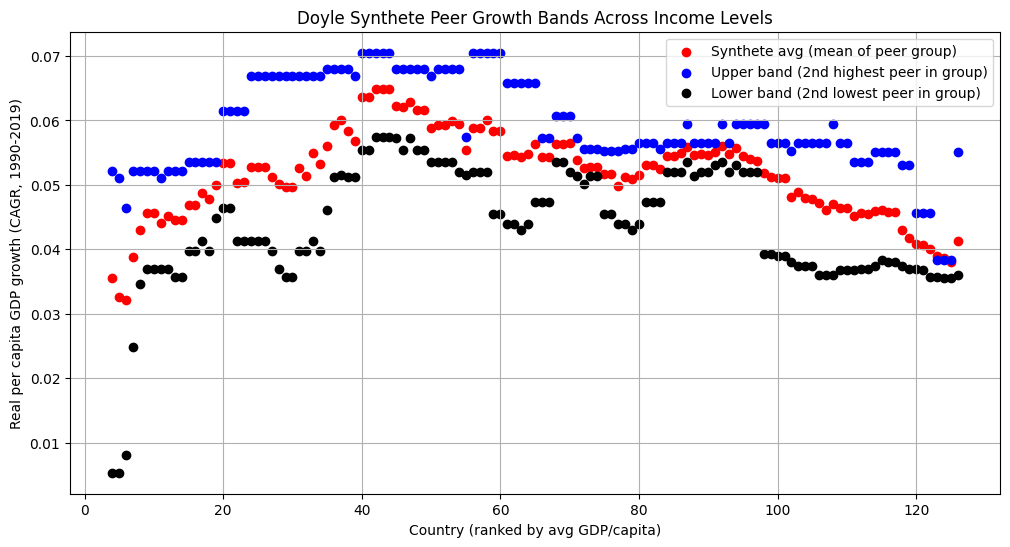

In [ ]:
# TODO: could add additional analysis from Peter's analysis
synthete_results = get_all_synthete_stats_vectorized(
    all_data_df, neighbor_n=15, metric_col="cagr"
)
assert not synthete_results.is_empty()

# Extract arrays for plotting
synthete_mean = synthete_results["synthete_mean"].to_numpy()
band_second_best = synthete_results["band_second_best"].to_numpy()
band_second_worst = synthete_results["band_second_worst"].to_numpy()
gdp_capita_sort_idx = synthete_results["index"].to_numpy()
country_list = synthete_results["country"].to_list()

plt.figure(figsize=(12, 6))
plt.scatter(
    gdp_capita_sort_idx,
    synthete_mean,
    color="red",
    label="Synthete avg (mean of peer group)",
)
plt.scatter(
    gdp_capita_sort_idx,
    band_second_best,
    color="blue",
    label="Upper band (2nd highest peer in group)",
)
plt.scatter(
    gdp_capita_sort_idx,
    band_second_worst,
    color="black",
    label="Lower band (2nd lowest peer in group)",
)
plt.xlabel("Country (ranked by avg GDP/capita)")
plt.ylabel("Real per capita GDP growth (CAGR, 1990-2019)")
plt.title("Doyle Synthete Peer Growth Bands Across Income Levels")
plt.legend()
plt.grid(True)
plt.show()

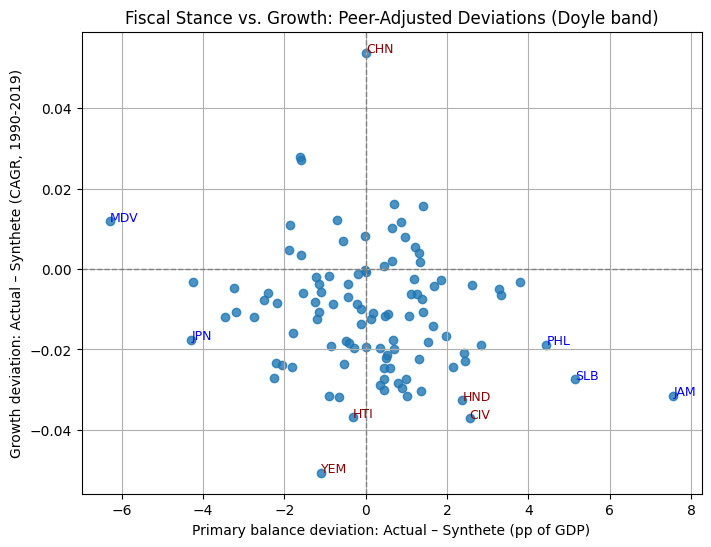

In [4]:
# Peer Group Deviation Analysis for right-primary.pdf
# Compare each country's (actual pb_final – synthete pb_final) vs (actual cagr – synthete mean cagr)
deviation_analysis = get_all_synthete_means_vectorized(all_data_df, neighbor_n=15)

assert not deviation_analysis.is_empty()

# Compute deviations using Polars
deviation_analysis = deviation_analysis.with_columns(
    [
        (pl.col("actual_pb") - pl.col("synth_pb")).alias("dev_pb"),
        (pl.col("actual_cagr") - pl.col("synth_cagr")).alias("dev_cagr"),
    ]
)

# Extract for plotting
dev_pb = deviation_analysis["dev_pb"].to_numpy()
dev_cagr = deviation_analysis["dev_cagr"].to_numpy()
country_codes = deviation_analysis["country"].to_list()

# Plotting code remains the same
plt.figure(figsize=(8, 6))
plt.scatter(dev_pb, dev_cagr, alpha=0.8)
plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.axvline(0, color="grey", linestyle="--", linewidth=1)
plt.xlabel("Primary balance deviation: Actual – Synthete (pp of GDP)")
plt.ylabel("Growth deviation: Actual – Synthete (CAGR, 1990-2019)")
plt.title("Fiscal Stance vs. Growth: Peer-Adjusted Deviations (Doyle band)")
plt.grid(True)

# Top outliers annotation
if len(dev_pb) > 0 and len(dev_cagr) > 0:
    for i in np.argsort(np.abs(dev_cagr))[-5:]:
        plt.annotate(
            country_codes[i], (dev_pb[i], dev_cagr[i]), fontsize=9, color="darkred"
        )
    for i in np.argsort(np.abs(dev_pb))[-5:]:
        plt.annotate(
            country_codes[i], (dev_pb[i], dev_cagr[i]), fontsize=9, color="blue"
        )

plt.show()

## What do 'growth deviation actual synthete' and 'primary balance deviation actual synthete' mean?

**Growth deviation (Actual Synthete):**
- This measures how much a country's real per capita economic growth rate (CAGR) from 1990 to 72019 differed from the *average* growth rate achieved by its "synthete peer group" (a band of similar countries matched by income level).
- **Interpretation:**
    - A *positive* value means the country grew faster than its synthete twin average (it "beat its peers").
    - A *negative* value means it underperformed compared to the peer group's typical growth rates.

**Primary balance deviation (Actual Synthete):**
- This measures how much a country's average government primary balance (budget savings/borrowing, excluding interest), as a % of GDP, was higher or lower than the *mean* primary balance in its synthete peer group from 1990 to 72019.
- **Interpretation:**
    - A *positive* value means the country ran a *tighter* budget than its synthete peers (higher average primary balance, i.e., more saving or less borrowing).
    - A *negative* value means it ran a *looser* budget (lower primary balance, i.e., more spending/borrowing than the average in its peer group).

**In summary:**
- These deviations allow us to compare not just absolute growth or budget tightness, but how a country's *relative fiscal stance* versus similar economies might be linked to its *relative economic performance*.

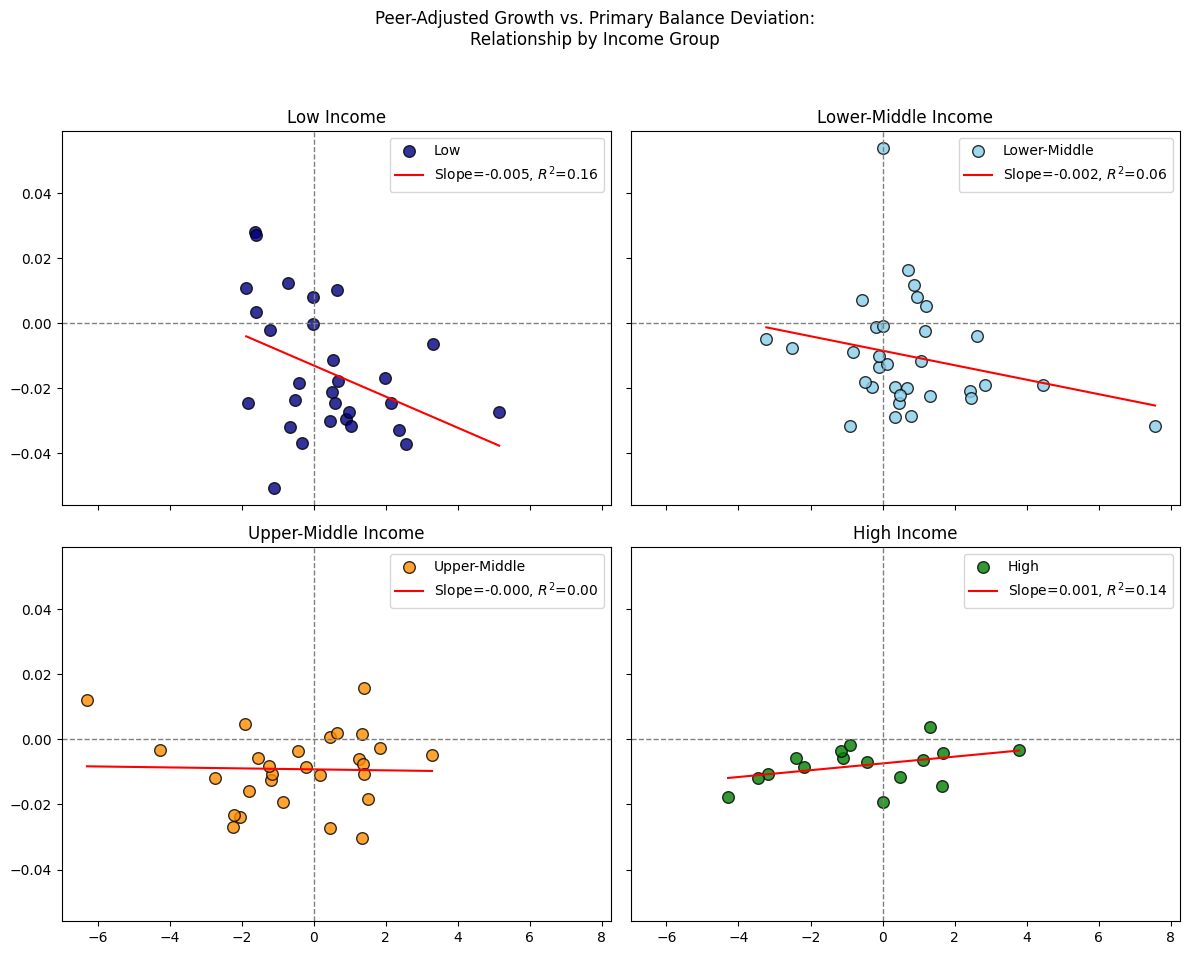

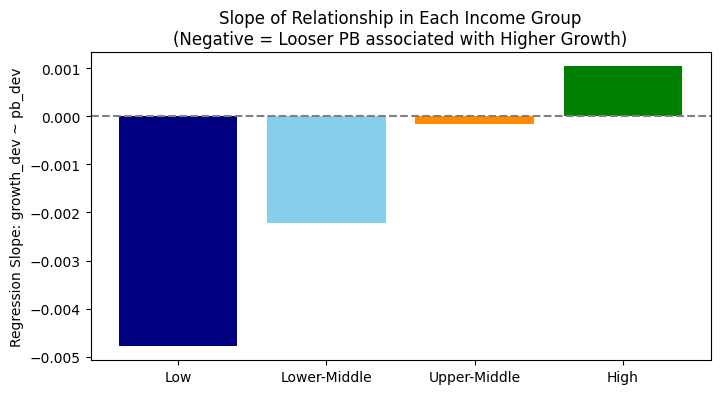


Regression Statistics by Income Group:
--------------------------------------------------
Low             | N= 29 | Slope=-0.0048 | R²=0.1582
Lower-Middle    | N= 32 | Slope=-0.0022 | R²=0.0610
Upper-Middle    | N= 28 | Slope=-0.0001 | R²=0.0007
High            | N= 16 | Slope= 0.0010 | R²=0.1444


In [18]:
# Join to main dataframe for deviation analysis
analysis_df = (
    all_data_df.drop("index") if "index" in all_data_df.columns else all_data_df
)

# Get synthete means for all countries
synthete_means_df = compute_all_synthete_means(analysis_df)

# Join with main dataframe and filter out nulls
analysis_result_df = (
    analysis_df
    .join(synthete_means_df, on="country")
    .filter(
        pl.col("average_primary_balance").is_not_null() &
        pl.col("synth_pb").is_not_null() &
        pl.col("synth_cagr").is_not_null()
    )
    .with_columns([
        pl.col("average_primary_balance").alias("actual_pb"),
        pl.col("cagr").alias("actual_cagr"),
        (pl.col("average_primary_balance") - pl.col("synth_pb")).alias("dev_pb"),
        (pl.col("cagr") - pl.col("synth_cagr")).alias("dev_cagr")
    ])
)

# Assign income groups using Polars cut function or when/then
bins = [0, 4000, 12000, 30000, float("inf")]
labels = ["Low", "Lower-Middle", "Upper-Middle", "High"]

analysis_result_df = analysis_result_df.with_columns([
    pl.when(pl.col("average_gdp_per_capita") < 4000)
    .then(pl.lit("Low"))
    .when(pl.col("average_gdp_per_capita") < 12000)
    .then(pl.lit("Lower-Middle"))
    .when(pl.col("average_gdp_per_capita") < 30000)
    .then(pl.lit("Upper-Middle"))
    .otherwise(pl.lit("High"))
    .alias("income_group")
])

# Compute regression stats for each income group
group_stats = {}
for group in labels:
    group_data = analysis_result_df.filter(pl.col("income_group") == group)
    group_stats[group] = compute_group_regression(group_data)

# Colors for plotting
colors = {
    "Low": "navy",
    "Lower-Middle": "skyblue",
    "Upper-Middle": "darkorange",
    "High": "green",
}

# Create facet plot
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

for i, group in enumerate(labels):
    group_data = analysis_result_df.filter(pl.col("income_group") == group)
    
    if len(group_data) == 0:
        continue
        
    x = group_data["dev_pb"].to_numpy()
    y = group_data["dev_cagr"].to_numpy()
    ax = axs[i // 2, i % 2]
    
    # Scatter plot
    ax.scatter(x, y, color=colors[group], label=group, alpha=0.8, s=70, edgecolor="k")
    
    # Regression line if we have enough points
    stats = group_stats[group]
    if not np.isnan(stats["slope"]):
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = stats["slope"] * x_range + stats["intercept"]
        ax.plot(
            x_range, y_pred,
            color="red", linestyle="-",
            label=f"Slope={stats['slope']:.3f}, $R^2$={stats['r2']:.2f}"
        )
    
    # Formatting
    ax.axhline(0, color="grey", linestyle="--", linewidth=1)
    ax.axvline(0, color="grey", linestyle="--", linewidth=1)
    ax.set_title(f"{group} Income")
    ax.legend()

fig.suptitle(
    "Peer-Adjusted Growth vs. Primary Balance Deviation:\nRelationship by Income Group"
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Slope summary bar plot
reg_slopes = [group_stats[group]["slope"] for group in labels]

plt.figure(figsize=(8, 4))
plt.bar(labels, reg_slopes, color=[colors[g] for g in labels])
plt.axhline(0, color="grey", linestyle="--")
plt.ylabel("Regression Slope: growth_dev ~ pb_dev")
plt.title(
    "Slope of Relationship in Each Income Group\n(Negative = Looser PB associated with Higher Growth)"
)
plt.show()

# Print regression statistics
print("\nRegression Statistics by Income Group:")
print("-" * 50)
for group in labels:
    stats = group_stats[group]
    n_obs = len(analysis_result_df.filter(pl.col("income_group") == group))
    print(f"{group:15} | N={n_obs:3d} | Slope={stats['slope']:7.4f} | R²={stats['r2']:6.4f}")

## What did we learn about primary balance targets and growth?

**Summary (in plain English):**

We compared each country to a band of peer countries that are similar in average GDP per person. We looked at whether running a tighter (higher) or looser (lower) government primary balance than your peers affected how much better or worse your economy grew over 1990–2019.

**How did we do it?**
- For every country, we found its economic twins: countries with similar income per person over time.
- We looked at the government's average primary balance (how much it saved or borrowed, ignoring debt interest) and growth in income per person.
- We checked: did countries that ran much tighter budgets than their peers achieve higher growth than peer expectations?
  
**What did we find?**

- For most countries, there is **no evidence** that being much tougher or looser on budget targets than your peers systematically delivers better or worse economic growth. In fact, the relationship is very weak everywhere.
- **In poorer countries**, we actually saw a small pattern: countries that ran *looser* budgets than their peers (meaning, governments spent more and saved less than expected) tended to do slightly *better* on growth relative to their peers.

### Example:
- Imagine Mali is a low-income country, and its synthete peers (economic twins) ran tight budgets. Mali, though, ran a looser budget (more spending, less saving than its twins). According to our findings, Mali would have been more likely to beat its peer group on economic growth than if it had held to a stricter fiscal target like its peers.

- By contrast, if Germany (a high-income country) runs a looser or tighter primary balance than its twins, it doesn't seem to matter much for growth—it's almost random relative to its peer set.

**Why does this matter?**

- For policymakers in low- and lower-middle-income countries, aiming for very strict government savings (big positive primary balances) might be counterproductive if the cost is less investment or needed public spending. Our results say that "fiscal space"—the ability to spend or invest even if it means a looser budget—can help growth, at least when compared to similar economies.

- For richer countries, tinkering with tighter or looser budget targets doesn't make much difference for their growth compared to their peers—other factors likely matter more.

**In short:**  Tightening the government belt more than your peer group isn't a magic formula for growth, and for poorer countries, being too strict could even hold them back.

CFA: slope=-0.0081, intercept=-0.0178, R^2=0.7502


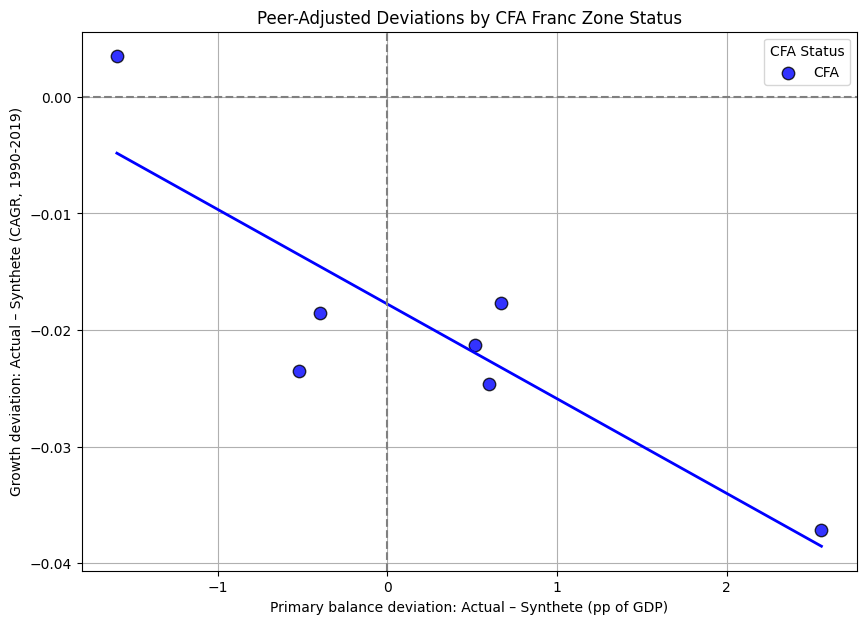

In [17]:
# 1. Mark CFA and non-CFA franc zone countries
CFA_COUNTRIES = [
    "BEN",
    "BFA",
    "CIV",
    "MLI",
    "NER",
    "SEN",
    "TGO",
    "GNB",  # WAEMU
    "CMR",
    "COG",
    "GAB",
    "GNQ",
    "CAF",
    "TCD",  # CEMAC
]

analysis_result_df = analysis_result_df.with_columns(
    [
        pl.when(pl.col("country").is_in(CFA_COUNTRIES))
        .then(pl.lit("CFA"))
        .otherwise(pl.lit("Other"))
        .alias("cfa_status")
    ]
)


cfa_colors = {"CFA": "blue"}
cfa_labels = ["CFA"]

plt.figure(figsize=(10, 7))
for group in cfa_labels:
    # Filter data for this group using Polars
    group_data = analysis_result_df.filter(pl.col("cfa_status") == group)
    
    if len(group_data) == 0:
        print(f"{group}: no data points.")
        continue
        
    # Extract data as numpy arrays
    x = group_data["dev_pb"].to_numpy()
    y = group_data["dev_cagr"].to_numpy()
    
    # Scatter plot
    plt.scatter(
        x, y,
        alpha=0.8,
        label=group,
        c=cfa_colors.get(group, "grey"),
        s=80,
        edgecolor="k",
    )

    # OLS per group using scikit-learn
    if len(x) > 1:
        # Fit regression
        reg = LinearRegression().fit(x.reshape(-1, 1), y)
        y_pred = reg.predict(x.reshape(-1, 1))
        r2 = r2_score(y, y_pred)
        
        # Plot regression line
        x_range = np.linspace(x.min(), x.max(), 100)
        y_line = reg.predict(x_range.reshape(-1, 1))
        
        plt.plot(
            x_range, y_line,
            color=cfa_colors.get(group, "grey"),
            linestyle="-",
            lw=2,
        )
        
        # Print regression stats
        print(f"{group}: slope={reg.coef_[0]:.4f}, intercept={reg.intercept_:.4f}, R^2={r2:.4f}")
    else:
        print(f"{group}: too few data points for regression.")

plt.axhline(0, color="grey", linestyle="--")
plt.axvline(0, color="grey", linestyle="--")
plt.xlabel("Primary balance deviation: Actual – Synthete (pp of GDP)")
plt.ylabel("Growth deviation: Actual – Synthete (CAGR, 1990-2019)")
plt.title("Peer-Adjusted Deviations by CFA Franc Zone Status")
plt.legend(title="CFA Status")
plt.grid(True)
plt.show()

## What do we learn about CFA and non-CFA franc zone countries?

We compared CFA franc zone countries and non-CFA countries to see if the relationship between government budget balance (primary balance) and economic growth (relative to their economic peers) is different by currency regime.

**How was this done?**  
For each country, we measured:
- How much tighter/looser their *average primary balance* was vs. a band of very similar (synthete) countries.
- Whether they grew faster or slower than those synthete peers from 1990–2019.
- Then looked for patterns by CFA status: CFA, non-CFA, and Other.

**What did the results show?**

- **CFA countries:** Running a much tighter government budget (primary balance) than their synthete peers was associated with _lower_ growth relative to the peer band. The regression slope is negative and R² is quite high, showing a clear pattern in this subgroup!
    - **Example:** If Senegal (a CFA member) kept government budgets tighter than its neighbors, it tended to underperform in growth compared to those neighbors.

- **Non-CFA countries:** The pattern is much weaker. For non-CFA countries, being tighter or looser than their peers on the budget makes very little difference for relative growth performance. The regression barely shows any effect.
    - **Example:** For Ghana (non-CFA), whether it ran slightly more prudent or looser budgets than similar-income West African countries didn't really change whether it beat or lagged those peers in growth over the period.

- **Other countries:** For those outside both groups, there is also no meaningful link between tightness of budget stance (vs peers) and relative growth.

**Key Takeaways:**

- **In the CFA zone, aiming for a tighter government budget than similar countries tended to hurt—not help—growth relative to your economic peers.**
- **For non-CFA African and peer countries, fiscal stringency or looseness didn't make a systematic difference to peer-relative long-term growth.**

**Why is this important?**
- For CFA franc zone policymakers: Pushing for much tighter budgets than your neighbors, over long periods, may reduce your country's economic performance _relative to those peers_. Rigid fiscal targets should be reassessed, especially if the goal is faster convergence with similar economies.

**Summary with examples:**
- Imagine Benin (CFA) and Cabo Verde (non-CFA), both small West African economies. If Benin targets a very tight government budget and Cabo Verde is more flexible, only Benin is likely to see growth fall short of its synthete peers—Cabo Verde's growth seems unaffected by its stance relative to synthete expectations.

This suggests that the fiscal rules or external constraints specifically in the CFA currency zone might drive this difference, not simply "spending more means growing less" or vice versa.

